# Tensor Completion

*Completing* a tensor means filling out its missing values. It's the equivalent of interpolation for the case of discretized tensor grids.

In [9]:
import torch
torch.set_default_dtype(torch.float64)
import tntorch as tn
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

We will start by reading a text image and masking out 90% of its pixels:

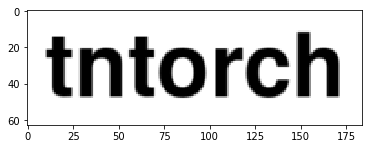

We will keep 1159 out of 11592 pixels


In [10]:
im = torch.DoubleTensor(plt.imread('../images/text.png'))
plt.imshow(im, cmap='gray', vmin=im.min(), vmax=im.max())
plt.show()

P = im.shape[0]*im.shape[1]
Q = int(P/10)
print('We will keep {} out of {} pixels'.format(Q, P))
X = np.unravel_index(np.random.choice(P, Q), im.shape)  # Coordinates of surviving pixels
y = torch.Tensor(im[X])  # Grayscale values of surviving pixels

The masked image looks like this:

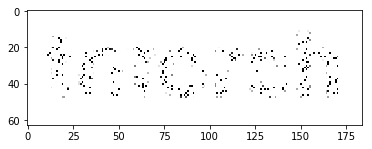

In [11]:
mask = np.ones([im.shape[0], im.shape[1]])
mask[X] = y
plt.imshow(mask, cmap='gray', vmin=im.min(), vmax=im.max())
plt.show()

Now, we will try to recover the image by completing a rank-6 tensor with those samples:

iter: 0      | loss:   1.178050 | total time:    0.0009
iter: 500    | loss:   0.200007 | total time:    0.5207
iter: 1000   | loss:   0.084521 | total time:    1.0735
iter: 1500   | loss:   0.021333 | total time:    1.6547
iter: 2000   | loss:   0.003651 | total time:    2.2765
iter: 2187   | loss:   0.001562 | total time:    2.5357 <- converged (tol=0.0001)


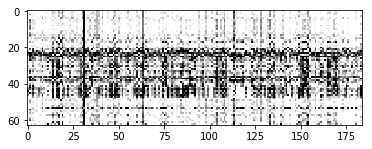

In [12]:
t = tn.rand(im.shape, ranks_tt=6, requires_grad=True)

def loss(t):
    return tn.relative_error(y, t[X])
tn.optimize(t, loss)

plt.imshow(t.numpy(), cmap='gray', vmin=im.min(), vmax=im.max())
plt.show()

The result is not convincing since we are not using any notion of spatial correlation: the real world signal is smooth, but our tensor does not know about that.

## Smoothness Priors

This time we will add a penalization term in the hope of getting a smoother reconstruction. We will use the norm of the tensor's 2nd-order derivatives, for which we can use [the function *partialset()*](derivatives.ipynb). To combine (add) both losses, we need to return them as a tuple from the `loss()` function:

iter: 0      | loss:   1.172050 +   2.569117 =      3.741 | total time:    0.0037
iter: 500    | loss:   0.120569 +   0.085111 =     0.2057 | total time:    2.4681
iter: 1000   | loss:   0.063130 +   0.021324 =    0.08445 | total time:    4.9900
iter: 1500   | loss:   0.053652 +   0.010877 =    0.06453 | total time:    7.6926
iter: 2000   | loss:   0.046964 +   0.008748 =    0.05571 | total time:   10.2740
iter: 2500   | loss:   0.037407 +   0.008513 =    0.04592 | total time:   12.8340
iter: 3000   | loss:   0.025241 +   0.007971 =    0.03321 | total time:   15.2129
iter: 3500   | loss:   0.015514 +   0.006649 =    0.02216 | total time:   17.7566
iter: 4000   | loss:   0.010046 +   0.005578 =    0.01562 | total time:   19.9821
iter: 4500   | loss:   0.006938 +   0.005028 =    0.01197 | total time:   22.7111
iter: 5000   | loss:   0.005096 +   0.004723 =   0.009818 | total time:   25.3216
iter: 5500   | loss:   0.004118 +   0.004510 =   0.008628 | total time:   28.6819
iter: 6000   | l

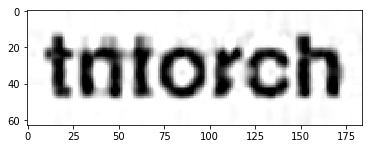

In [13]:
t = tn.rand(im.shape, ranks_tt=6, requires_grad=True)

def loss(t):
    return tn.relative_error(y, t[X])**2, tn.normsq(tn.partialset(t, order=2))*1e-4
tn.optimize(t, loss)

plt.imshow(t.numpy(), cmap='gray', vmin=im.min(), vmax=im.max())
plt.show()